Ok. The first thing we must do is to have a distribution that corresponds to what we expect the task duration will look like. 
It should have an offset on X to be near 1 (say 0.8) and then follow a Weibull distribution after that. 

Let's first generate a Weibull distro that resembles task completion profiles

## Step 1. Create, and display the PDF for the duration of a task using Weibull


median
3.0704183105271543
average
3.3767640449664547
max
9.313319704189885


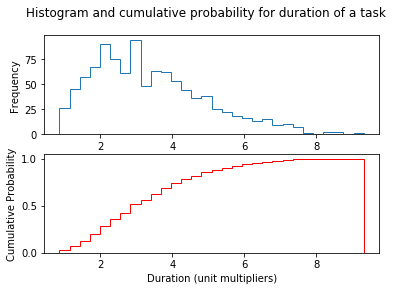

In [69]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import random
import statistics as st

n = 1000     # number of samples
shape_Beta = 1.69     # shape or Beta 
scale_lambda = 2.9456  # scale or theta / Lambda
starting_offset = 0.8 # because tasks rarely last less than expected, and if they do, only a bit

x = weibull_min.rvs(shape_Beta, loc=starting_offset, scale=scale_lambda, size=n)


##To obtain two subplots, pass parameters 2, 1 for two rows and one column.
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Histogram and cumulative probability for duration of a task')

## plot the histogram of possible durations
ax1.hist(x, density=False, histtype='step', bins=30, cumulative=False)
ax1.set(ylabel='Frequency', xlabel='Duration (unit multipliers)')

## print also the cumulative probability 
ax2.hist(x, density=True, histtype='step', bins=30, cumulative=True, color="red")
ax2.set(ylabel='Cumulative Probability', xlabel='Duration (unit multipliers)')


## print median, average, max
print("median")
print(st.median(x))
print("average")
print(st.mean(x))
print("max")
print(max(x))


Now, the problem is that the Median should probably be closer to 1 (the estimated duration of a task), so we need a different shape so that it is higher frequency of durations around the value of 1. 
## Step 2. Find the Weibull that fits empirical task duration (1 -> actual = estimated)

median
1.2104506485738429
average
1.2508890738714704
max
2.487815244521855


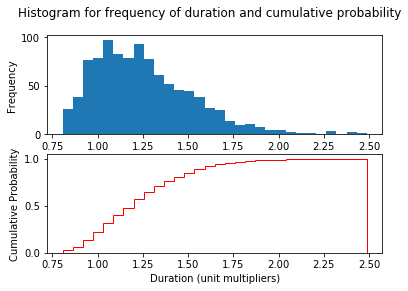

In [71]:
n = 1000     # number of samples
shape_Beta = 1.69     # shape or Beta 
scale_lambda = 0.5  # scale or theta / Lambda
starting_offset = 0.8 # because tasks rarely last less than expected, and if they do, only a bit

x = weibull_min.rvs(shape_Beta, loc=starting_offset, scale=scale_lambda, size=n)

##To obtain two subplots, pass parameters 2, 1 for two rows and one column.
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Histogram for frequency of duration and cumulative probability')

## plot the histogram of possible durations
bin_values, bins, patches = ax1.hist(x, density=False, histtype='barstacked', bins=30, cumulative=False)
ax1.set(ylabel='Frequency', xlabel='Duration (unit multipliers)')
## print also the cumulative probability 
ax2.hist(x, density=True, histtype='step', bins=30, cumulative=True, color="red")
ax2.set(ylabel='Cumulative Probability', xlabel='Duration (unit multipliers)')


## print median, average, max
print("median")
print(st.median(x))
print("average")
print(st.mean(x))
print("max")
print(max(x))




The Weibull distribution with these parameters seems to be closer to empirical data. 

So, now we know that our distribution parameters should be Shape parameter (Beta) = 1.69, and the scale parameter (Theta) should be 0.5. 

**Caveat**: Although these parameters constrain the right side of the distribution to a max around 2 or 3, which does not cover the full range of possible task durations, we will run our simultation with these parameters and the Weibull distribution.

Let's continue and setup a toy project of only 2 tasks. Then we will use the Weibull distribution to generate independently the duration for each of these two tasks, and finally the duration for the project. 

**Note**: For this simultation, we are using duration multipliers, so a duration of "1" in this example means that the actual duration of a task is the same as estimated.

## Step 3. Simulating a project of N (num_tasks) tasks
Let's simulate a project of N (num_tasks) tasks and find it's 50%, 75% probability duration as well as it's probability of being 'on time' (e.g. perfect estimate)

acceptable_duration 12.5(error: 0.25)
number of tasks in project: 10
maximum estimated duration for normalized tasks (task duration = 1): 10

median project duration 
12.43780017613648
average project duration
12.508474145466371
max project duration
15.573908067355958
min project duration
10.07208909957511
acceptable_duration 12.5(error: 0.25)
Probability of a perfect estimate: 58.699999999999996%


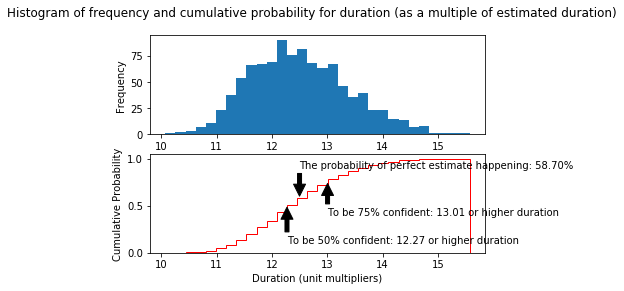

In [183]:
def durations_of_a_task( samples, b_shape, lam_scale, loc_offset ):
    return weibull_min.rvs(shape_Beta, loc=starting_offset, scale=scale_lambda, size=samples)

def sum_tasks_at_position( task_vector, num_tasks, position ):
    sum = 0
    for i in range( num_tasks ): 
        sum = sum + task_vector[i][position]
    return( sum )

def project_durations( task_vector, samples, num_tasks ):
    ## generate the durations of one task (for num_tasks) according to Weibull with selected parameters
    for i in range(num_tasks):
        task_vector.append( durations_of_a_task( n, shape_Beta, scale_lambda, starting_offset ) )
        
    project_durations_vector = [] ## will contain all the possible durations of the project as simulated
    for i in range( samples ): 
        project_durations_vector.append( sum_tasks_at_position( task_vector, num_tasks, i) )
    return project_durations_vector

def get_probability_of_perfect_estimate( project_durations_vector, num_tasks, acceptable_error ):
    ## NOTE: 'acceptable_error' is how long the project is allowed to last over the ideal and still be considered "on time"
    acceptable_duration = num_tasks * (1 + acceptable_error)
    print("acceptable_duration "+str(acceptable_duration)+"(error: "+str(acceptable_error)+")")
    bin_values_cumul, bins_cumul, patches = ax2.hist(project_durations_vector, density=True, 
                                                 histtype='step', bins=30, cumulative=True, color="red")


    ## Find the last bin that lasts num_tasks or less
    ## ANNOTATE: the "perfect accuracy" probability
    ## Find Y location for the perfect estimate (= num_tasks)
    probability_of_perfect_estimate = 0
    x_loc_for_perfect_estimate = 0
    for i in range(len(bins_cumul)):
        if bins_cumul[i] > acceptable_duration:
            probability_of_perfect_estimate = bin_values_cumul[i-1]
            break

    return( probability_of_perfect_estimate )

def get_XX_prob_duration( bin_values_cumul, bins_cumul, probability):
    x_loc_for_XX_prob = 0
    for i in range(len(bin_values_cumul)):
        if bin_values_cumul[i] >= probability:
            x_loc_for_XX_prob = bins_cumul[i]
            break
    return( x_loc_for_XX_prob )

def get_50_prob_duration( bin_values_cumul, bins_cumul ):
    return( get_XX_prob_duration( bin_values_cumul, bins_cumul, 0.5) )

def get_75_prob_duration( bin_values_cumul, bins_cumul ):
    return( get_XX_prob_duration( bin_values_cumul, bins_cumul, 0.75) )


def plot_project_frequency_and_cumulative_histograms( project_durations_vector, num_tasks, acceptable_error_in_estimate  ): 
    ##################
    ## Now we plot 2 graphs
    ## The first graph will have the frequency of durations (note that perfect estimation would be a duration of 2 - beacuse we are simulating a 2-task long project/critical path)
    ## The second graph is the cumulative probabilities for each possible duration of the project

    ## PLOT: To obtain two subplots, pass parameters 2, 1 for two rows and one column.
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('Histogram of frequency and cumulative probability for duration (as a multiple of estimated duration)')

    ## PLOT: create the histogram of possible durations
    bin_values, bins, patches = ax1.hist(project_durations_vector, density=False, 
                                         histtype='barstacked', bins=30, cumulative=False)
    ax1.set(ylabel='Frequency', xlabel='Duration (unit multipliers)')

    ## PLOT: create also the cumulative probability histogram
    bin_values_cumul, bins_cumul, patches = ax2.hist(project_durations_vector, density=True, 
                                                     histtype='step', bins=30, cumulative=True, color="red")
    ax2.set(ylabel='Cumulative Probability', xlabel='Duration (unit multipliers)')
    ## ANNOTATE: the 50% probability point and the 75% point
    ## Find the X location for the 50% probability
    x_loc_for_50_prob = get_50_prob_duration( bin_values_cumul, bins_cumul )
    
    formated_location_value = '%.2f' % x_loc_for_50_prob
    annotation_txt = "To be 50% confident: "+str(formated_location_value)+" or higher duration"

    ax2.annotate(annotation_txt, xy=(x_loc_for_50_prob, 0.5), xytext=(x_loc_for_50_prob, 0.1),
                arrowprops=dict(facecolor='black', shrink=0.05), )


    ## ANNOTATE: the 75% probability point and the 75% point
    ## Find the X location for the 50% probability
    x_loc_for_75_prob = get_75_prob_duration( bin_values_cumul, bins_cumul )

    formated_location_value = '%.2f' % x_loc_for_75_prob
    annotation_txt = "To be 75% confident: "+str(formated_location_value)+" or higher duration"

    ax2.annotate(annotation_txt, xy=(x_loc_for_75_prob, 0.75), xytext=(x_loc_for_75_prob, 0.40),
                arrowprops=dict(facecolor='black', shrink=0.05), )

    ## ANNOTATE: the "perfect accuracy" probability
    ## Find Y location for the perfect estimate (= num_tasks)
    x_loc_for_perfect_estimate = num_tasks * (1+acceptable_error_in_estimate)
    y_loc_for_perfect_estimate = get_probability_of_perfect_estimate( project_durations_vector, 
                                                            num_tasks, acceptable_error_in_estimate )

    formated_location_value = '%.2f' % (y_loc_for_perfect_estimate * 100) ## in percent value
    annotation_txt = "The probability of perfect estimate happening: "+str(formated_location_value)+"%"

    ax2.annotate(annotation_txt, xy=(x_loc_for_perfect_estimate, y_loc_for_perfect_estimate), 
                 xytext=(x_loc_for_perfect_estimate, 0.9), 
                 arrowprops=dict(facecolor='black', shrink=0.05), )



    ## print median, average, max
    print("number of tasks in project: " + str(num_tasks))
    print("maximum estimated duration for normalized tasks (task duration = 1): " + str(1*num_tasks))
    print()
    print("median project duration ")
    print(st.median(project_durations_vector))
    print("average project duration")
    print(st.mean(project_durations_vector))
    print("max project duration")
    print(max(project_durations_vector))
    print("min project duration")
    print(min(project_durations_vector))
    
            
num_tasks = 10 ## how many tasks in the project
task_vector = [] ## will contain the simulated durations of all tasks (each tasks is simulated N times - see above)
acceptable_error_in_estimate = 0.1 ## 25% error is acceptable

## Project durations (up to 'n' samples andn with 'num_tasks' tasks)
project_durations_vector = project_durations( task_vector, n, num_tasks )

plot_project_frequency_and_cumulative_histograms(project_durations_vector, num_tasks, acceptable_error_in_estimate)
prob_perfect_estimate = get_probability_of_perfect_estimate( project_durations_vector, 
                                                            num_tasks, acceptable_error_in_estimate ) * 100
print("Probability of a perfect estimate: "+ str(prob_perfect_estimate)+"%")



What is the probability of a project being delivered on time for the simulation above? 